In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def random_seq(length=250):
    indices = np.random.randint(0, 3, size=(length))
    chars = ["a", "c", "g", "t"]
    sequence = []
    for index in indices:
        sequence.append(chars[index])
    
    return sequence

In [17]:
def get_reads_from(seq, read_len=200, coverage=5):
    L = len(seq)
    read_amt = int(L/read_len * coverage)
    reads = []
    for _ in range(read_amt):
        start = np.random.randint(0,L-read_len)
        read = seq[start:start+read_len]
        reads.append(read)
    return reads

In [18]:
def parse_nucleotides(sequence):
    new_seq = []
    map_to_vals = {"a": 1, "c": 2, "g": 3, "t":4}
    for symbol in sequence:
        new_seq.append(map_to_vals[symbol])
        
    return new_seq

In [19]:
def getskmer(snippet, profile):
    spaced_kmer = snippet * profile
    spaced_kmer = spaced_kmer[spaced_kmer != 0]
    s = ''.join(str(x) for x in spaced_kmer)
    return s

In [20]:
def get_maxcount(pos, seqs, seqs_kmers, spaced_kmer_profile, seq_to_investigate=0):
    target = seqs[seq_to_investigate]
    f = len(spaced_kmer_profile)
    counts_i = []
    indexes = []
    len_loop = min(f-1, pos)
    start = pos-len_loop
    end = pos+1
    for i in range(start, end):
        if spaced_kmer_profile[pos-i] != 1:
            counts_i.append(0)
            indexes.append(-1)
            continue
        
        # Extract k mers starting at selected position
        spaced_kmer = target[i : i+f] * spaced_kmer_profile
        spaced_kmer = spaced_kmer[spaced_kmer != 0]
        s = ''.join(str(x) for x in spaced_kmer)
        counts_i.append(seqs_kmers[s])
        indexes.append(i)
    
    return max(counts_i), indexes[np.argmax(counts_i)]

In [25]:
def get_correction_profile(target, seqs, overlap_size):
    corr_profile = [0 for i in range(len(target)-overlap_size)]
    #corr_profile[0] = -1
    for i in range(len(target)-overlap_size):
        #
        #if i == 0:
            # Note that this whole check is necessary because our target sequence, i.e. the read we are investigating at the moment
            # also starts at the beginning and would thus be added to the count profile. We anticipate this by increasing the correction
            # profile at this point to one s.t. the loop below can reduce it to zero in the first step if just our sequence starts there.
            # If another sequence starts here, then the loop below will reduce the correction profile below zero
            #corr_profile[0] = 1
        for seq in seqs:
            if (target[i : i+overlap_size] == seq[0 : overlap_size]).all(): # starts
                corr_profile[i] -= 1
            elif (target[i : i+overlap_size] == seq[len(seq)-overlap_size : len(seq)]).all(): # ends
                corr_profile[i] += 1
    corr_profile[0]=0
    return corr_profile

In [26]:
#
# CORRECT COUNTS - AN ATTEMPT AT FIXING THE ECLIPSE ERROR
#
def correct_counts(maxed_counts, maxed_count_indices, target_sequence, start_end_posis, seqs, diff_profile, kmer_profile):
    f = len(kmer_profile)
    correction_artifact = []
    last_correction = 0 
    # When corrections are necessary they are written into the maxed_counts array
    for i in range(1,len(maxed_count_indices)):
        # Make sure we have a change position on our hands.
        if maxed_counts[i] != maxed_counts[i-1]: 
            # Correct for reads that start in between the two maxed_count indices:
            #start_sum_at = max(i-f,0)
            #start_sum_at = max(0, maxed_count_indices[i-1]-f+1)
            '''
            start_sum_at = maxed_count_indices[i-1]
            end_sum_at = maxed_count_indices[i]+1
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            '''
            start_sum_at = last_correction
            end_sum_at = maxed_count_indices[i]+1
            #end_sum_at = i+1
            
            if start_sum_at <= end_sum_at:
                correction = sum(start_end_posis[start_sum_at:end_sum_at])
            else:
                correction = -sum(start_end_posis[end_sum_at:start_sum_at])
                
            # This if clause tries to prevent the eclipse
            # The important part of this is that the last_correction is not updated if we have a SNP or seqerr
            #if diff_profile[i-1] + correction == 0: # If not we have a SNP or seq error
            last_correction = maxed_count_indices[i] + 1
            diff_profile[i-1] += correction
            correction_artifact.append([correction, (start_sum_at, end_sum_at), start_end_posis[start_sum_at:end_sum_at]])
            
            #else:
                #print("ABORTED:")
                #print(end_sum_at)
                #print(start_end_posis[start_sum_at:end_sum_at])
    return diff_profile, correction_artifact

In [27]:
def correct_diff_profile(filename, str_profile, seq_to_investigate, data=[]):
    seqs = []
    if data:
        for read in data:
            sequence_chars = [val for val in read]
            sequence = parse_nucleotides(sequence_chars)
            seqs.append(np.array(sequence))
    else:
        with open(filename) as file_in:
            for line in file_in:
                newline = line.rstrip('\n')
                sequence_chars = [char for char in newline]
                sequence = parse_nucleotides(sequence_chars)
                seqs.append(np.array(sequence))
    
    profile = [int(character) for character in str_profile]
    k = sum(profile)
    f = len(profile)
    
    # Turn into np arrays for componentwise multiplication
    profile = np.array(profile)
    
    # Count occurence of spaced k-mers
    seqs_kmers = {}
    for sequence in seqs:
        for i in range(len(sequence) - f):
            spaced_kmer = sequence[i:i+f] * profile
            spaced_kmer = spaced_kmer[spaced_kmer != 0]
            s = ''.join(str(x) for x in spaced_kmer)
            if s not in seqs_kmers:
                seqs_kmers[s] = 1
            else:
                seqs_kmers[s] += 1
    
    # Get maxcounts from counts
    target = seqs[seq_to_investigate]
    xpoints = np.array([i for i in range(len(target) - f)])
    max_counts = []
    max_count_indices = []
    for i in range(len(xpoints)):
        maxp, argmaxp = get_maxcount(i, seqs, seqs_kmers, profile, seq_to_investigate=seq_to_investigate)
        max_counts.append(maxp)
        max_count_indices.append(argmaxp)
    #print(max_count_indices)
    # Get correction profile:
    start_end_posis = get_correction_profile(target, seqs, f)
    #print(start_end_posis)
    #print(max_count_indices)
    
    # Get diff profile:
    pre_corr_diff_profile = [max_counts[j] - max_counts[j-1] for j in range(1,len(max_counts))]
    
    # Apply correction strategy
    ypoints, correction_artifact = correct_counts(max_counts, max_count_indices, target, start_end_posis, seqs, pre_corr_diff_profile.copy(), profile)
    return xpoints[1:], ypoints, max_counts, start_end_posis, pre_corr_diff_profile, correction_artifact, max_count_indices


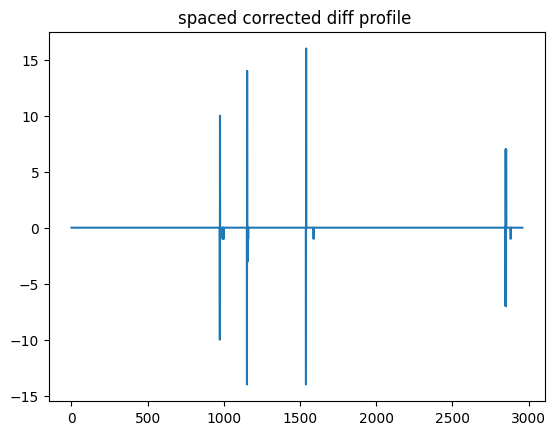

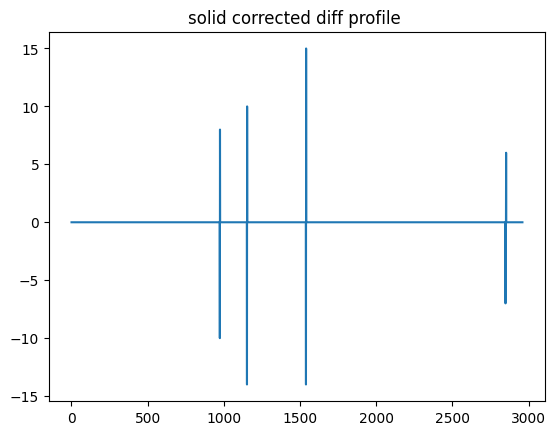

In [30]:
#
xpoints, ypoints, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "1111110110110101110101011101011111101111", 1)
xpoints_solid, ypoints_solid, _, _, _, _, _ = correct_diff_profile("./data/twostrains.txt", "1111111111111111111111111111111111111111", 1)
#
plt.title("spaced corrected diff profile ")
plt.plot(xpoints, ypoints)
plt.show()
#
plt.title("solid corrected diff profile ")
plt.plot(xpoints_solid, ypoints_solid)
plt.show()